In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from traj_helpers import get_trajectories, normalize_trajectory, resample_trajectory, plot_trajectory
from traj_dataset import TrajDataset
from autoencoders import MLP_VAE
from loss import traj_mse_loss, kl_loss
import numpy as np

TRAINING_DIRS = ['mocap_dataset/strokes']
FINETUNE_DIRS = ['mocap_dataset/stars']
DRAWING_DIRS = TRAINING_DIRS + FINETUNE_DIRS
LATENT_DIM = 64
POINTS_PER_TRAJ = 32
BETA = 0.000001

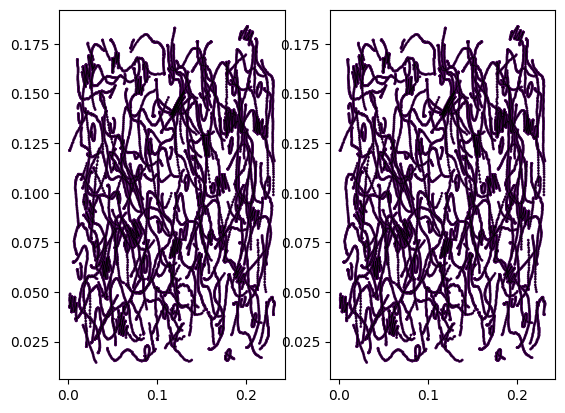

In [2]:
# Plot all the paintings
fig, axs = plt.subplots(1, len(DRAWING_DIRS), squeeze=False)
for (i, dir) in enumerate(DRAWING_DIRS):
    trajectories = get_trajectories([dir])

    for traj in trajectories:
        plot_trajectory(axs[0][i], traj)

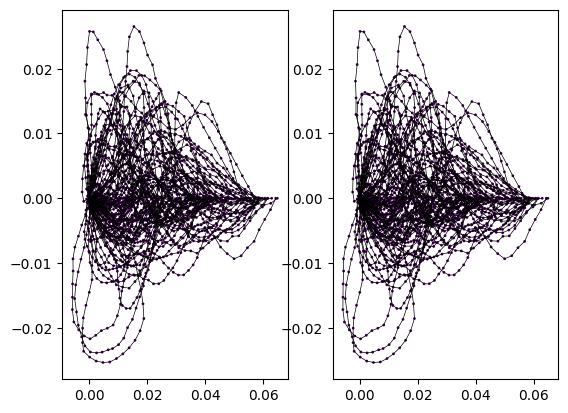

In [3]:
training_trajectories = get_trajectories(TRAINING_DIRS)
finetune_trajectories = get_trajectories(FINETUNE_DIRS)

def filter_trajectories(trajectories):
    # Filter out trajectories that zigzag too much
    filtered_trajectories = []
    for trajectory in trajectories:
        zigzag_score = 0
        cur_angle = -1
        for j in range(1, len(trajectory)):
            angle = np.arctan2(trajectory[j][1] - trajectory[j-1][1], trajectory[j][0] - trajectory[j-1][0])
            length = np.linalg.norm(trajectory[j] - trajectory[j-1])
            if cur_angle == -1:
                cur_angle = angle
            else:
                angle_diff = abs(angle - cur_angle) % (2 * np.pi)
                angle_diff = min(angle_diff, 2 * np.pi - angle_diff)
                zigzag_score += angle_diff * length
                cur_angle = angle
        # if zigzag_score < 0.02:
        if zigzag_score < 100 and len(trajectory) >= 2:
            filtered_trajectories.append(trajectory)
    return filtered_trajectories

training_trajectories = filter_trajectories(training_trajectories)
finetune_trajectories = filter_trajectories(finetune_trajectories)

for i in range(len(training_trajectories)):
    training_trajectories[i] = normalize_trajectory(training_trajectories[i])
    training_trajectories[i] = resample_trajectory(training_trajectories[i], num_points=POINTS_PER_TRAJ)

for i in range(len(finetune_trajectories)):
    finetune_trajectories[i] = normalize_trajectory(finetune_trajectories[i])
    finetune_trajectories[i] = resample_trajectory(finetune_trajectories[i], num_points=POINTS_PER_TRAJ)

fig, axs = plt.subplots(1, 2)
idx = 0
cnt = 100
for trajectory in training_trajectories[idx:idx+cnt]:
    plot_trajectory(axs[0], trajectory)
for trajectory in finetune_trajectories[idx:idx+cnt]:
    plot_trajectory(axs[1], trajectory)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP_VAE(
    input_points_per_traj=POINTS_PER_TRAJ,
    latent_dim=LATENT_DIM,
    output_points_per_traj=POINTS_PER_TRAJ
)
model.to(device)

def train(model, trajectories, epochs, lr):
    dataset = TrajDataset(trajectories)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output, mean, logvar = model(batch)
            mse = traj_mse_loss(batch, output)
            kl = kl_loss(mean, logvar)
            loss = mse + BETA * kl
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(epoch, loss.item())

train(model, training_trajectories, 1000, 0.001)
train(model, finetune_trajectories, 300, 0.001)

0 0.011179983615875244
10 0.0008626593044027686
20 0.0002462827251292765
30 0.00015368693857453763
40 0.00013569495058618486
50 0.00010597133950795978
60 0.00010908563126577064
70 9.852574294200167e-05
80 0.00010471012501511723
90 0.00010161182581214234
100 8.527432510163635e-05
110 9.617184696253389e-05
120 8.480772521579638e-05
130 9.264860273106024e-05
140 8.699099271325395e-05
150 9.274674812331796e-05
160 7.327061030082405e-05
170 9.948403749149293e-05
180 0.00010175029456149787
190 0.0001095412953873165
200 8.135529060382396e-05
210 7.312517846003175e-05
220 8.073805656749755e-05
230 7.074442692101002e-05
240 0.00010891733109019697
250 5.772459553554654e-05
260 7.338697469094768e-05
270 7.001541962381452e-05
280 8.690834511071444e-05
290 5.3119485528441146e-05
300 7.959284266689792e-05
310 6.940008461242542e-05
320 7.643841672688723e-05
330 5.48586540389806e-05
340 6.222394586075097e-05
350 5.905775833525695e-05
360 5.9746234910562634e-05
370 7.452027057297528e-05
380 6.843209121

(32, 3)


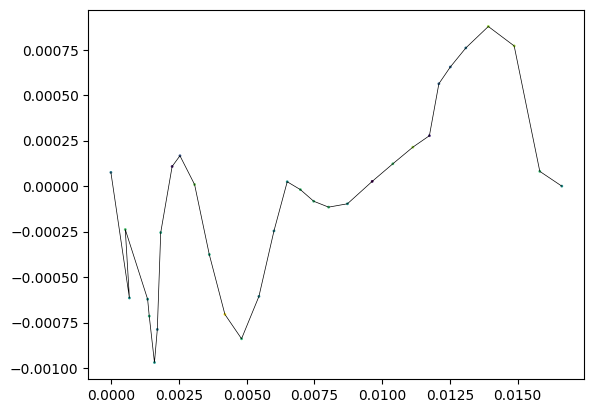

In [29]:
# Visualize generated trajectories
generated_trajectories = model.sample_trajectories(100)
fig, ax = plt.subplots()
idx = 0
cnt = 1
for trajectory in generated_trajectories[idx:idx+cnt]:
    plot_trajectory(ax, trajectory)

In [6]:
# Save model
torch.save(model.state_dict(), 'saved_models/stars.pt')